# Classification Based Approaches

# 1. KNN

We used KNN as an example as to why our agent should not use classification methods using state-action pairsto solve the issue. Initially, KNN needs all of its moves to be scaled into a determined set. Since there is so much different terrain, it is harder for it to adapt once a new unseen terrain is added or when an object moves to a new location relative to the frame.

Another issue for KNN is the curse of dimensionality. This dataset is composed of two numpy arrays: a 3D array that describes the environment and a 1D array that describes the action taken. In many cases in training, our players did drastically different actions at the same observation or the same action at a slightly different observation. Therefore, KNN has difficulties in finding similarities between records. This resulted in our KNN model taking vast amounts of time for training off of a singular isloated run and thus not finishing. 

# 2. Decision Trees
We also used a decision tree to further demonstrate how classification using state-action pairs was inappropriate for our problem. Our data is filled with many occurrences of the same observation but slightly different actions in reaction to the same environment. 
In one run, the same person could jump at a frame earlier and thus not jump at the consequent frame or the same person could jump
at the consequent frame and not do anything in the frame prior. This makes it difficult for the agent to draw similarities
between runs, making it hard for the tree to fit an action to a specific state. 

# 3. ADABoosting
We used ADABoosting as an example as to why our agent should not use classification methods using state-action pairs to play super mario. Though the accuracy of the boosting model is generally higher than techniques alone, in our case, since we are using ensembling in a supervised learning way based on the decision tree stump model, the ensemble booster model accuracy is ____. Since the goal of our classification is to classify in a way that allows the model to beat the super mario game, the application of ensembling wouldn't be the best as it would base the action it takes strictly on the states ran through by a mario play-through done by the user, which could be susceptible to faulty playthroughs. If we were to apply an RL agent on the other hand which creates policies on the premise of maximizing rewards as our model for ADABoosting, it would likely be a good approach as the accuracy would be increased substantially.

# 4. Proximal Policy Optimization using Stable Baselines 3
Insert an explanation of PPO here, why we used it, etc.


In [13]:
# All necessary imports
from nes_py.wrappers import JoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from gym_utils import SMBRamWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

%matplotlib inline

### Defining Callback and Helper Functions
The logging callback class is used to populate the score/time_step lists for later display.  
The linear schedule is derived from the stablebaselines documentation, and is considered a standard approach for PPO.

In [25]:
class EvaluationCallback(BaseCallback):

    def __init__(self, check_freq, env_wrap, starting_steps=0, verbose=1):
        super(EvaluationCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.starting_steps = starting_steps
        self.env_wrap = env_wrap
        self.evaluations = []

    def _init_callback(self):
        print("Initialized Callback")

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            eval = evaluate_policy(self.model, self.env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
            self.evaluations.append(eval[0])
        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [26]:
# Create the environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4
env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)
env_wrap = Monitor(env_wrap)
env_wrap = DummyVecEnv([lambda: env_wrap])


In [27]:
day_time = datetime.today().strftime("%m%d%y_%H%M%S")
MODEL_DIR = './models/PPO_' + day_time
LOG_DIR = './logs/'

In [28]:
model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4)) 

In [29]:
callback = EvaluationCallback(check_freq=250, starting_steps=0, env_wrap = env_wrap)

In [30]:
#Training the model
t_start = time.time()
model.learn(total_timesteps=10e3, callback=callback)
t_elapsed = time.time() - t_start
print('Wall time: {} s'.format(round(t_elapsed, 2)))
# Save model
model_path = os.path.join(MODEL_DIR)
model.save(model_path)

Initialized Callback
Wall time: 439.26 s


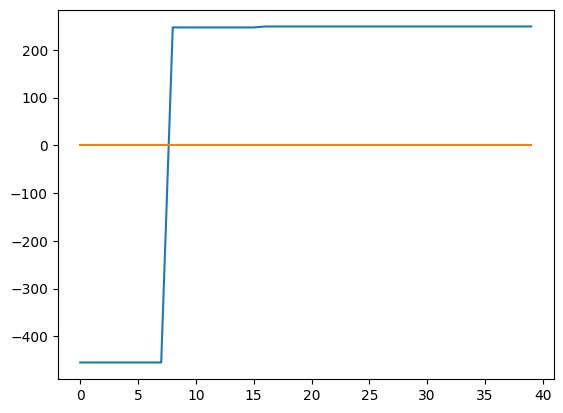

In [31]:
# evaluate the model
evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
plt.figure()
plt.plot(callback.evaluations)
plt.show()

In [32]:
episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))

c:\Users\lucam\miniconda3\envs\yumouwei\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Episode:1 Score:[249.]


In [33]:
env.close()

In [34]:
callback.evaluations

[(-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (-455.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (247.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0),
 (249.0, 0.0)]